# Problem Set 1 (110 points) 

## Important information
We provide signatures of the functions that you have to implement. Make sure you follow the signatures defined, otherwise your coding solutions will not be graded.

Read [homework rules](https://nbviewer.jupyter.org/github/oseledets/nla2018/blob/master/hw.pdf) carefully. <font color='red'>If you do not follow it you will likely be penalized.</font>

# Problem 1 (Python demo) 40 pts

## Data preparation (10 pts)

* First of all download $\verb|.wav|$ file with starcraft sound from [here](https://github.com/oseledets/nla2018/tree/master/psets). Load it in python and play using the following functions:

In [1]:
from scipy.linalg import toeplitz
import numpy as np
import math
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib notebook

In [ ]:
plt.rcParams.update({'font.size': 12})

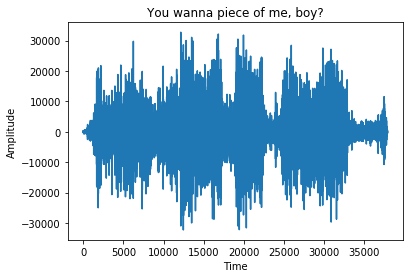

In [2]:
# reading
rate, audio = wav.read("TMaRdy00.wav")

# plotting
plt.plot(audio)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("You wanna piece of me, boy?")
plt.show()

# playing
Audio(audio, rate=rate)

Our next goal is to process this signal by multiplying it by a special type of matrix (convolution operation) that will smooth the signal. 

* (5 pts) Before processing this file let us estimate what size of matrix we can afford. Let $N$ be the size of the signal. Estimate analytically memory in megabytes required to store dense square matrix of size $N\times N$ to fit in your operation memory and print this number. Cut the signal so that you will not have swap (overflow of the operation memory). **Note:** Cut the signal by taking every p-th number in array: ```signal[::p]```. 

In [3]:
N = audio.nbytes
memory_matrix = (N*N) 
print(memory_matrix/1024/1024)

5476.0


In [4]:
signal=audio[::4]
N = audio.nbytes
memory_matrix = (N*N) 
print('memory:',memory_matrix/1024/1024,'')
print('size in bytes:', memory_matrix)

memory: 5476.0 
size in bytes: 5742002176


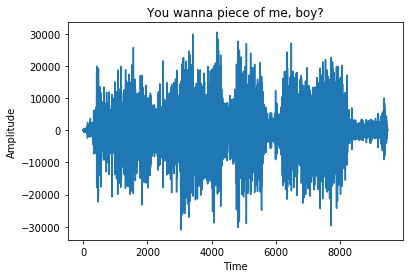

In [5]:
plt.plot(signal)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("You wanna piece of me, boy?")
plt.show()

Audio(signal, rate=rate/4)

* (5 pts) Write a function 
```python
def gen_toeplitz(N, alpha):    
    return T
```
that outputs matrix $T$: $$T_{ij} = \sqrt{\frac{\alpha}{\pi}}e^{-\alpha (i-j)^2}, \quad i,j=1,\dots,N$$ as numpy array. <font color='red'> Avoid using loops or lists! </font> The function [np.meshgrid](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.meshgrid.html) will be helpful for this task.
**Note:** matrices that depend only on difference of indices: $T_{ij} \equiv T_{i-j}$ are called **Toeplitz**. Toeplitz matrix-by-vector multiplication is **convolution** since it can be written as $$y_i = \sum_{j=1}^N T_{i-j} x_j.$$ Convolutions can be computed faster than $\mathcal{O}(N^2)$ complexity using Fast Fourier transform (will be covered later in our course, no need to implement it here).

In [6]:
# INPUT: N - integer (positive), alpha - float (positive)
# OUTPUT: T - np.array (shape: NxN)

def gen_toeplitz(N, alpha):
    i,j=np.meshgrid(np.linspace(1,N,N),np.linspace(1,N,N))
    T=np.sqrt(alpha/math.pi)*math.e**((-alpha*(i-j)**2))
    return T

## Convolution (10 pts)

* (5 pts) Write a function ```convolution``` (see below)
that takes the signal you want to convolve and multiply it by Toeplitz matrix T (for matvec operations use @ symbol). 

In [7]:
# INPUT: signal - np.array (shape: Nx1), N - int (positive), alpha - float (positive)
# OUTPUT: convolved_signal - np.array (shape: Nx1)

def convolution(signal, N, alpha):
    convolved_signal = gen_toeplitz(N,alpha)@signal
    return convolved_signal

* (3 pts) Plot the first $100$ points of the result and the first $100$ points of your signal on the same figure. Do the same plots for $\alpha = \frac{1}{5}$, $\alpha = \frac{1}{100}$ using ```plt.subplots``` in matplotlib. Each subplot should contain first $100$ points of initial and convolved signals for some $\alpha$. Make sure that you got results that look like smoothed initial signal.

* (2 pts) Play the resulting signal. In order to do so you should also scale the frequency (rate), which is one of the inputs in `Audio`.  
Note that you cannot play a signal which is too small.

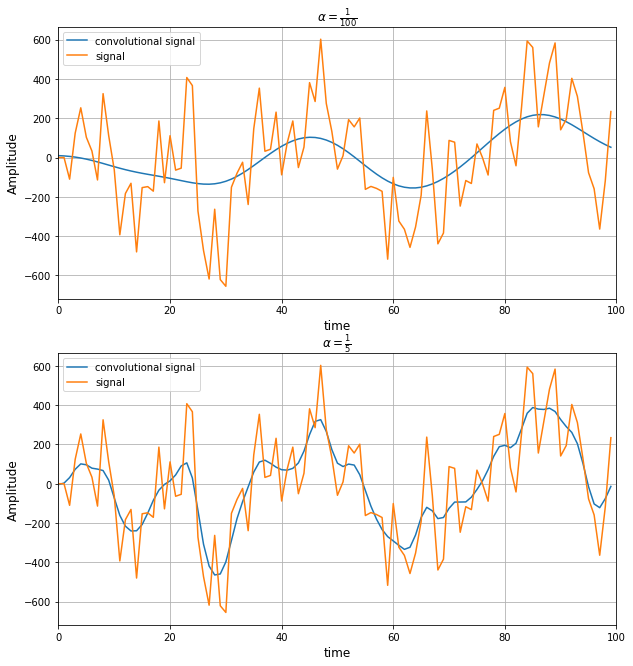

In [200]:
alpha100 = 1.0/100.0
alpha5 = 1.0/5.0
signal100 = signal[0:100]
N = len(signal100)

conv_100 = convolution(signal100,N,alpha100)
conv_5 = convolution(signal100,N,alpha5)

plt.figure(figsize=(10,11))

plt.subplot(211)
plt.plot(conv_100,label='convolutional signal')
plt.plot(signal100,label='signal')
plt.ylabel("Amplitude",fontsize=12)
plt.xlabel("time",fontsize=12)
plt.title(r"$\alpha = \frac{1}{100}$",fontsize=12)
plt.xlim(0,100)
plt.grid()
plt.legend()

plt.subplot(212)
plt.plot(conv_5,label='convolutional signal')
plt.plot(signal100,label='signal')
plt.ylabel("Amplitude",fontsize=12)
plt.title(r"$\alpha = \frac{1}{5}$",fontsize=12)
plt.xlabel("time",fontsize=12)
plt.xlim(0,100)
plt.grid()
plt.legend()

In [11]:
#alpha = 1/100
Audio(conv_100, rate=rate/4)

In [12]:
#alpha = 1/5
Audio(conv_5, rate=rate/4)

## Deconvolution (20 pts)

Given a convolved signal $y$ and an initial signal $x$ our goal now is to recover $x$ by solving the system
$$
    y = Tx.
$$
To do so we will run iterative process
$$
    x_{k+1} = x_{k} - \tau_k (Tx_k - y), \quad k=1,2,\dots
$$
starting from zero vector $x_0$. There are different ways how to define parameters $\tau_k$.
Different choices lead to different methods (e.g. Richardson iteration, Chebyshev iteration, etc.).
This topic will be covered in details later in our course.

To get some intuition why this process converges to the solution of $Tx=y$, we can consider the following. Let us note that if $x_k$ converges to some limit $x$, then so does $x_{k+1}$. Taking $k\to \infty$ we arrive at $x = x - \tau (Tx -  y)$ and hence $x$ is the solution of $Tx = y$. 

Another important point is that iterative process requires only matrix-vector porducts $Tx_k$ on each iteration instead of the whole matrix. In this problem we, however, work with the full matrix, but keep in mind, that convolution can be done efficiently without storing the whole matrix.

* (5 pts) For each $k$ choose paremeter $\tau_k$ such that the residual $r_{k+1}=Tx_{k+1} - y$ is minimal possible (*line search* with search direction $r_k$):
$$
    \|Tx_{k+1} - y\|_2 \to \min_{\tau_k}
$$
found analytically. The answer to this bullet is a derivation of $\tau_k$. The parameter $\tau_k$ should be expressed in terms of residuals $r_k = T x_k - y$.

**Finding optimal $\tau_k$**

$$\min_{\tau_k} \|Tx_{k+1} -y\|$$

Let $$x_{k+1} = x_{k} - \tau_k (Tx_k - y), \quad k=1,2,\dots$$ Then $Tx_{k+1} -y = Tx_k - \tau_k T r_k -y = r_k-\tau_k Tr_k$. We should minimize  $\| r_k-\tau_k Tr_k\|$, it is the same to minimize $$\|r_k-\tau_k Tr_k\|_2^2 = (r_k-\tau_k Tr_k)^T (r_k-\tau_k Tr_k) = r_k^T r_k - 2\tau_k r_k^T Tr_k + \tau_k^2 r_k^T T^2 r_k$$ Now we need to differentiate reslut by $\tau_k$ : 
$$-2r_k^T T r_k+2\tau_kr_k^T T^2 r_k=0$$

Finally,
$$\tau_k = \frac{r_k^T T r_k}{r_k^T T^2 r_k}$$ 

In [13]:
def tau_k(T,rk):
    tau_k=T@rk@rk/(T@rk@T@rk)
    return tau_k

* (10 pts) Write a function ```iterative```
that outputs accuracy –– a numpy array of relative errors $\big\{\frac{\|x_{k+1} - x\|_2}{\|x\|_2}\big\}$ after ```num_iter``` iterations using $\tau_k$ from the previous task. **Note:** The only loop you are allowed to use here is a loop for $k$.

In [16]:
# INPUT:  N - int (positive), alpha - float (positive), num_iter - integer (positive), 
#  y - np.array (shape: Nx1, convolved signal), s - np.array (shape: Nx1, original signal)
# OUTPUT: rel_error - np.array size (num_iter x 1)

def iterative(N, num_iter, y, s, alpha):
    x_k = np.zeros(N)
    T = gen_toeplitz(N, alpha)
    rel_error = np.zeros(num_iter)
    
    for k in range(num_iter):
        rk=T@x_k-y
        tau = tau_k(T,rk)
        x_k = x_k-tau*rk
        rel_error[k]= np.linalg.norm(x_k-s,2)/np.linalg.norm(s,2)
    return rel_error

* (2 pts) Set ```num_iter=1000```, ```x=s[::20]``` and do a convergence plot for $\alpha = \frac{1}{2}$ and $\alpha = \frac{1}{5}$.

In [17]:
signal_20 = audio[::20]
N_20 = len(signal_20)
alpha2 = 1.0/2.0
conv1 = convolution(signal_20, N_20, 1.0/2.0)
conv5 = convolution(signal_20, N_20, 1.0/5.0)

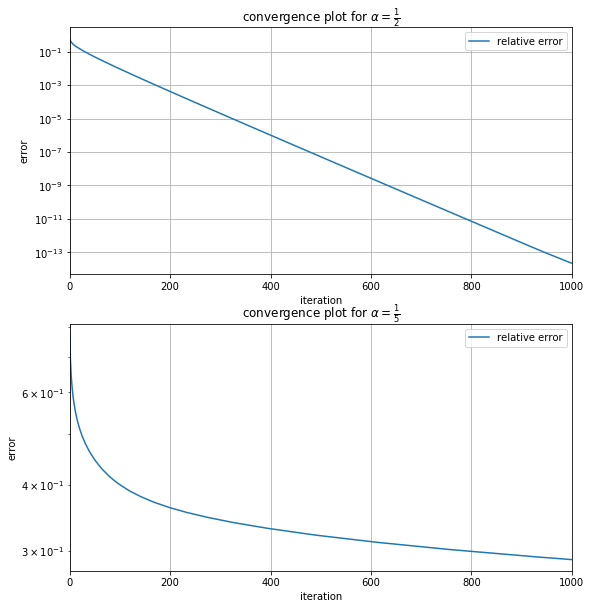

In [18]:
plt.figure(figsize=(9,10))

plt.subplot(211)
plt.title(r'convergence plot for $\alpha = \frac{1}{2}$')
plt.semilogy(iterative(N_20, 1000, conv1, signal_20, alpha2),label='relative error')
plt.ylabel("error")
plt.xlabel("iteration")
plt.xlim(0,1000)
plt.grid()
plt.legend()

plt.subplot(212)
plt.title(r'convergence plot for $\alpha = \frac{1}{5}$')
plt.semilogy(iterative(N_20, 1000, conv5, signal_20, alpha5),label='relative error')
plt.ylabel("error")
plt.xlim(0,1000)
plt.xlabel("iteration")
plt.grid()
plt.legend()

* (3 pts) Set ```x=s[::20]```, ```num_iter=1000``` and $\alpha=\frac{1}{5}$. Explain what happens with the convergence if you add small random noise of amplitude $10^{-3}\max(x)$  to $y$. The answer to this question should be an explanation supported by plots and/or tables.

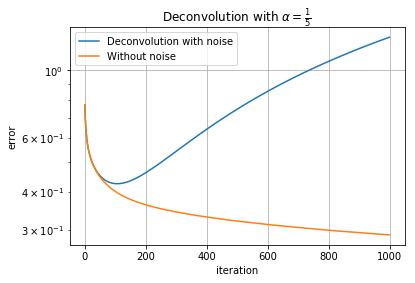

In [201]:
plt.figure(figsize=(6,4))
plt.semilogy(iterative(N_20, 1000, conv5 +1e-3 * np.random.rand(N_20)*max(signal_20), signal_20, alpha5),label='Deconvolution with noise')
plt.semilogy(iterative(N_20, 1000, conv5, signal_20, alpha5), label='Without noise')
plt.title(r'Deconvolution with $\alpha = \frac{1}{5}$')
plt.ylabel("error")
plt.xlabel("iteration")
plt.grid()
plt.legend()

# Problem 2 (Theoretical tasks)  45 pts

_1._
- (5 pts) Prove that $\| U A \|_F = \| A U \|_F = \| A \|_F$ for any unitary matrix $U$.
- (5 pts) Prove that $\| Ux \|_2 = \| x \|_2$ for any $x$ iff $U$ is unitary.
- (5 pts) Prove that $\| U A \|_2 = \| A U \|_2 = \| A \|_2$ for any unitary $U$.


## _1._Solution

1) We know that $$\| A \|_F^2 = trace(A^*A)$$ then
$$\| U A \|_F^2 = tr((UA)^*(UA)) = tr(A^*(U^*U)A) = tr(A^*A) = \| A \|_F^2$$

Analogically with help of cyclic permutation 
$$\| A U \|_F^2 = tr((AU)^*(AU)) = tr(U^*A^*AU) = tr(A^*AUU^*) =  \| A \|_F^2$$

2) From definition of unitary matrix $$\| Ux \|_2 = (Ux)^*(Ux) = x^*(U^*U)x = (1.2)$$ 

(=>) from unitarity U, we know $$U^*U=I$$ and $$(1.2) = {(x,x)}  = \|x\|_2$$

(<=) $$if (1.2) = \|x\|_2$$ then  $$(x, U^*Ux - x) = 0 => U^* U = I$$

3) We know that $$\Vert A \Vert_2 = \sigma_1(A) = \sqrt{\lambda_\max(A^*A)}$$ then $$\| U A \|_2 = \sqrt{\lambda_\max((UA)^*(UA))} = \sqrt{\lambda_\max(A^*(U^*U)A)} = \sqrt{\lambda_\max(A^*A)} = \| A \|_2$$
  


_2._
- (5 pts) Using the results from the previous subproblem, prove that $\| A \|_F \le \sqrt{\mathrm{rank}(A)} \| A \|_2$. _Hint:_ SVD will help you.
- (5 pts) Show that for any $m, n$ and $k \le \min(m, n)$ there exists $A \in \mathbb{R}^{m \times n}: \mathrm{rank}(A) = k$, such that $\| A \|_F = \sqrt{\mathrm{rank}(A)} \| A \|_2$. In other words, show that the previous inequality is not strict.
- (5 pts) Prove that if $\mathrm{rank}(A) = 1$, then $\| A \|_F  = \| A \|_2$.
- (5 pts) Prove that $\| A B \|_F \le \| A \|_2 \| B \|_F$.

## _2._ Solution

1. We know that $\| A \|_F = \sqrt{trace(A^*A)}$ with using SVD: $ A = USV^*$ => $$\sqrt{tr(A^*A)} = \sqrt{tr((USV^*)^*(USV^*))} = \sqrt{tr(VS(U^*U)SV^*)}  = \sqrt{tr(S^*S)} = \sqrt{(s,s)}$$  s has all singular values,

we know that $ \sigma_1  \geq \sigma_2 \geq ...  \geq \sigma_n$ and it means that 
$$\sqrt{(s,s)} \leq rank(A)*\sigma_1$$. As we know $\sigma_1 = \| A \|_2$, finally 

$$\| A \|_F \le \sqrt{\mathrm{rank}(A)} \| A \|_2$$

3.  Using SVD: $ A = USV^*$
$$ \|A\|_2 = \|USV^*\|_2 = \|S\|_2 = sup_{ x \neq 0} \frac{\|Sx\|_{2}}{\|x\|_{2}}  = sup_{ x \neq 0} \frac{(\sum x_i^2 \sigma _i ^2)^{1/2}}{(\sum x_i^2 )^{1/2}} = \sigma_1 $$

$ \|A\|_F = \|USV^*\|_F = \|S\|_F = (\sum \sigma_i^2 )^{1/2}  = (\sum_{i=1}^r \sigma_i^2(A))^{1/2}$ where $r$ is a rank of a matrix A. 

it is mean that if $\mathrm{rank}(A) = 1$, then $\| A \|_F  = \| A \|_2$. 

Also, it can be prove from 1.

4.  Using SVD: $ A = USV^*$
 $\|AB\|_F = \|USV^*B\|_F = \|SV^*B\|_F \leq \|(\sigma_1 I )V^*B\|_F  =  \sigma_1\|I V^*B\|_F  =  \|A\|_2 \|B\|_F $

_3._    
* (3 pts) Differentiate with respect to $A$ the function
$$
f(A) = \mathrm{sin}(x^\top A B C D x),
$$
where $x$ is a vector and $A, B, C, D$ are square matrices.

* (7 pts) Differentiate with respect to $y, A, X$ the function
$$f(y, A, X) = \mathrm{tr}(\mathrm{diag}(y) A X),$$
where $y \in \mathbb{R}^n$ and $A, X \in \mathbb{R}^{n \times n}$. Here 

$$
\mathrm{diag}(y)_{i, j} = 
    \begin{cases}
      y_i, & \text{if}\ i = j \\
      0, & \text{otherwise}
    \end{cases}
$$

# Problem 3 (Strassen algorithm) 15 pts

_1._ (3 pts) Implement the naive algorithm for squared matrix multiplication with explicit “for” cycles.

In [24]:
def naive_multiplication(A, B):
    """
    Implement naive matrix multiplication with explicit for cycles
    
    Parameters: Matrices A, B
    
    Returns: Matrix C = AB
    """
    n = A.shape[0]
    k = A.shape[1]
    m = B.shape[1]
    C = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            for s in range(k):
                C[i, j] += A[i, s] * B[s, j]
    return C

_2._ (7 pts) Implement the Strassen algorithm.

In [213]:
def split(matrix):
    M, N = matrix.shape
    M11 = matrix[0 : M//2, 0 : N//2]
    M12 = matrix[0 : M//2, N//2 :]
    M21 = matrix[M//2 :, 0 : N//2]
    M22 = matrix[M//2 :, N//2 :]
    
    return M11,M12,M21,M22

In [243]:
def strassen(A, B):
    """
    Implement Strassen algorithm for matrix multiplication 
    
    Parameters: Matrices A, B
    
    Returns: Matrix C = AB
    """
    M, N = A.shape
    X, Y = B.shape
    if (M <= 4 | N <= 4 | X <=4 | Y <=4):
        return A@B
    else:
        exp_len=int(np.ceil(np.log2(A.shape[0])))
        
        expand_shape = (2**exp_len, 2**exp_len)
        
        A_expand = np.zeros(expand_shape)
        B_expand = np.zeros(expand_shape)
        A_expand[:A.shape[0],:A.shape[1]]=A 
        B_expand[:B.shape[0],:B.shape[1]]=B 
    
        A11,A12,A21,A22 = split(A_expand)
        B11,B12,B21,B22 = split(B_expand)
        
        P1 = strassen((A11 + A22), (B11 + B22))
        P2 = strassen(A21 + A22, B11)
        P3 = strassen(A11, B12 - B22)
        P4 = strassen(A22, B21 - B11)
        P5 = strassen(A11 + A12, B22)
        P6 = strassen(A21 - A11, B11 + B12)
        P7 = strassen(A12 - A22, B21 + B22)
        
        C11 = P1 + P4 - P5 + P7
        C12 = P3 + P5
        C21 = P2 + P4
        C22 = P1 - P2 + P3 + P6

    C = np.vstack((np.hstack((C11, C12)), np.hstack((C21, C22))))
    return C

_3._ (5 pts) Compare three approaches: naive multiplication, Strassen algorithm and standard NumPy function. 
Provide a plot in log-scale of dependence between the matrix size and the runtime of multiplication. You will have three lines, do not forget to add legend, axis labels and other attributes (see our [requirements](https://nbviewer.jupyter.org/github/oseledets/nla2018/blob/master/hw.pdf))  
Consider the matrix size in the range of 100 to 700 with step 100, e.g. $n=100, 200,\ldots, 700$. 
Justify the results theoretically (e.g., use the known formulas for total multiplication complexity of naive and Strassen algorithms).

164 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
603 ms ± 18.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
796 µs ± 24.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.15 s ± 18.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.81 s ± 31.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.37 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.95 s ± 34.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
16.3 s ± 133 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
24.2 ms ± 666 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.17 s ± 167 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
39.9 s ± 482 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
71.7 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.19 s ± 184 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 18s ± 411 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
133 ms ± 3.13 ms per loop (mean ± std

NameError: name 'timings_ct' is not defined

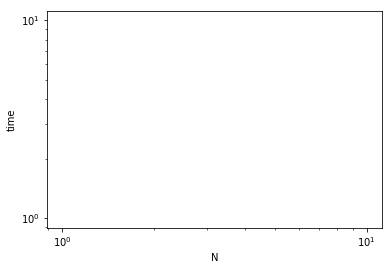

In [113]:
N = np.arange(100, 800, 100)
times_st = []
times_nm = []
times_np = []

for n in N:
    mtrx = np.random.randint(10,size=(n, n))

    ctime = %timeit -o  strassen(mtrx, mtrx)
    times_st.append(ctime.best)
    ctime = %timeit -o naive_multiplication(mtrx,mtrx)
    times_nm.append(ctime.best)
    ctime = %timeit -o  np.dot(mtrx,mtrx)
    times_np.append(ctime.best)

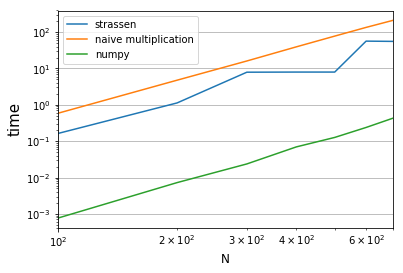

In [254]:
plt.xscale('log')
plt.yscale('log')
plt.ylabel('time',fontsize=15)
plt.xlabel('N',fontsize=12)
plt.plot(N, times_st, label='strassen')
plt.plot(N, times_nm, label='naive multiplication')
plt.plot(N, times_np, label='numpy')

plt.legend(loc='upper left')
plt.xlim(100,700)
plt.grid()
plt.show()

# Problem 4 (SVD) 10 pts
In this assignment you are supposed to study how SVD could be used in image compression.

_1._ (2 pts) Compute the singular values of some predownloaded image (via the code provided below) and plot them. Do not forget to use logarithmic scale.

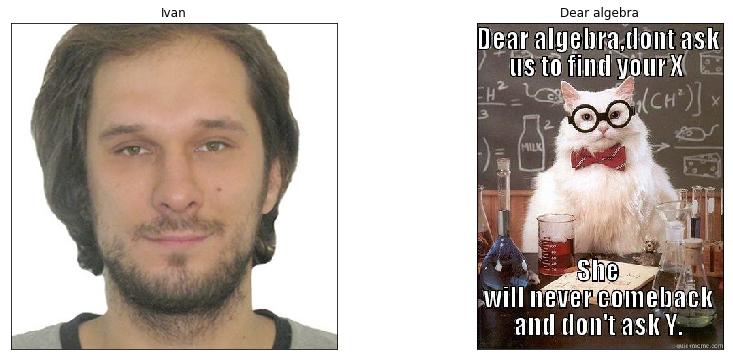

In [269]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import requests
import numpy as np


url = 'https://pbs.twimg.com/profile_images/1658625695/my_photo_400x400.jpg'  # Ivan
url1 = 'http://www.quickmeme.com/img/e3/e38bdd13bc8dd19873da87e971cb6a277b721355be0026dda4379d0bb3446c28.jpg' # your favorite picture, please!

face_raw = Image.open(requests.get(url, stream=True).raw)
face = np.array(face_raw).astype(np.uint8)


pic1 = Image.open(requests.get(url1, stream=True).raw)
pic1 = np.array(pic1).astype(np.uint8)

plt.figure(figsize=(14,6))

plt.subplot(121)
plt.imshow(face_raw)
plt.xticks(())
plt.yticks(())
plt.title('Ivan',fontsize=12)

plt.subplot(122)
plt.imshow(pic1)
plt.xticks(())
plt.yticks(())
plt.title('Dear algebra',fontsize=12)

plt.show()

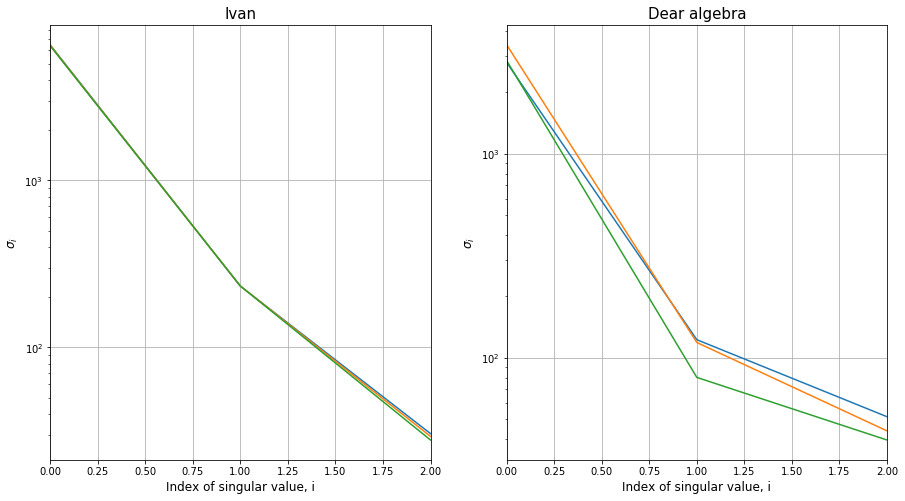

In [270]:
u,s,v=np.linalg.svd(face)
u1,s1,v1=np.linalg.svd(pic1)

plt.figure(figsize=(15,8))

plt.subplot(121)
plt.title('Ivan',fontsize=15)
plt.semilogy(s[0])
plt.semilogy(s[1])
plt.semilogy(s[2])
plt.ylabel(r"$\sigma_i$", fontsize=12)
plt.xlabel("Index of singular value, i", fontsize=12)
plt.xlim(0,2)
plt.grid()

plt.subplot(122)
plt.title('Dear algebra',fontsize=15)
plt.semilogy(s1[0])
plt.semilogy(s1[1])
plt.semilogy(s1[2])
plt.ylabel(r"$\sigma_i$", fontsize=12)
plt.xlabel("Index of singular value, i", fontsize=12)
plt.xlim(0,2)
plt.grid()

_2._ (3 pts) Complete a function ```compress```, that performs SVD and truncates it (using $k$ singular values/vectors). See the prototype below. 

Note, that in colourful case you have to split your image to channels and work with matrices corresponding to different channels separately.

Plot approximate reconstructed image $M_\varepsilon$ of your favorite image such that $rank(M_\varepsilon) = 5, 20, 50$ using ```plt.subplots```.

In [271]:
def compress(image, k):
    """
    Perform svd decomposition and truncate it (using k singular values/vectors)
    
    Parameters: 
        image (np.array):        input image (probably, colourful)
        
        k (int):                 approximation rank
        
    --------
    Returns:
      reconst_matrix (np.array): reconstructed matrix (tensor in colourful case)
      
      s (np.array):              array of singular values 
    """
    im = np.array(image).astype(np.uint8)
    
    u0,s0,v0 = np.linalg.svd(im[:,:,0])
    u1,s1,v1 = np.linalg.svd(im[:,:,1])
    u2,s2,v2 = np.linalg.svd(im[:,:,2])
    
    s = np.array([s0[:k],s1[:k],s2[:k]])

    reconst_matrix = np.zeros(image.shape)
    reconst_matrix[:,:,0] = u0[:,:k]@np.diag(s0[:k])@v0[:k,:]
    reconst_matrix[:,:,1] = u1[:,:k]@np.diag(s1[:k])@v1[:k,:]
    reconst_matrix[:,:,2] = u2[:,:k]@np.diag(s2[:k])@v2[:k,:]

    return reconst_matrix.astype(np.uint8), s[:,:k]

([], <a list of 0 Text yticklabel objects>)

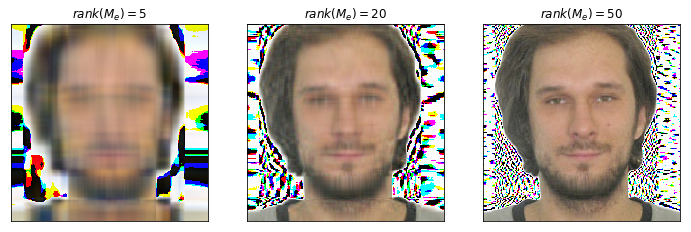

In [277]:
plt.figure(figsize=(12, 8))
plt.subplot(131)
rec_marix,s = compress(face, 5)
plt.xticks(())
plt.yticks(())
plt.title('$rank(M_e) = 5$')
plt.imshow(rec_marix)

plt.subplot(132)
rec_marix,s = compress(face, 20)
plt.xticks(())
plt.yticks(())
plt.title('$rank(M_e) = 20$')
plt.imshow(rec_marix)

plt.subplot(133)
rec_marix,s = compress(face, 50)
plt.title('$rank(M_e) = 50$')
plt.xticks(())
plt.yticks(())
plt.imshow(rec_marix)

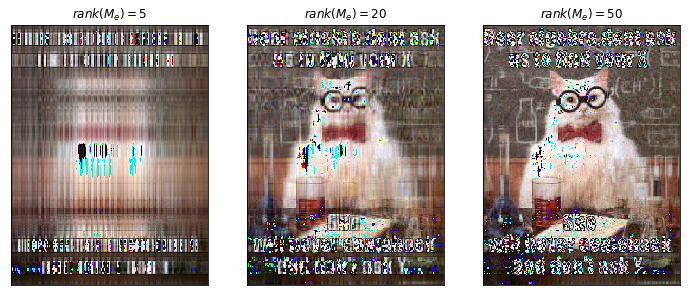

In [278]:
plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.title('$rank(M_e) = 5$')
rec_matrix,s=compress(pic1, 5)
plt.xticks(())
plt.yticks(())
plt.imshow(rec_matrix)

plt.subplot(132)
plt.title('$rank(M_e) = 20$')
rec_matrix,s=compress(pic1, 20)
plt.xticks(())
plt.yticks(())
plt.imshow(rec_matrix)

plt.subplot(133)
plt.title('$rank(M_e) = 50$')
rec_matrix,s=compress(pic1, 50)
plt.xticks(())
plt.yticks(())
plt.imshow(rec_matrix)

_3._ (3 pts) Plot the following two figures for your favorite picture
* How relative error of approximation depends on the rank of approximation?
* How compression rate in terms of storing information ((singular vectors + singular numbers) / total size of image) depends on the rank of approximation?

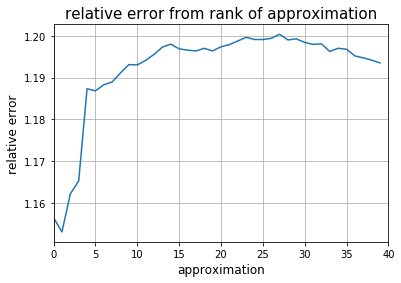

In [293]:
rel_error=np.array([])
for j in range(1,80,2):
    rel_error=np.append(rel_error,np.linalg.norm(pic1-compress(pic1,j)[0])/np.linalg.norm(pic1))
    
plt.plot(rel_error)
plt.title('relative error from rank of approximation', fontsize=15)
plt.ylabel('relative error', fontsize=12)
plt.xlabel('approximation', fontsize=12)
plt.xlim(0,40)
plt.grid()

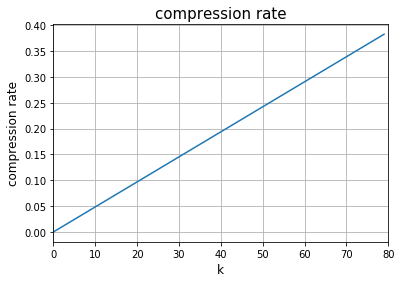

In [296]:
def compression_rate(image,k):
    im = np.array(image).astype(np.uint8)
    
    u0,s0,v0 = np.linalg.svd(im[:,:,0])
    u1,s1,v1 = np.linalg.svd(im[:,:,1])
    u2,s2,v2 = np.linalg.svd(im[:,:,2])
    
    compression_rate = np.array([])
    for j in range(k): 
        compression_rate = np.append(compression_rate, (3*(u0[:,:j].size+s0[:j].size+v0[:j].size))/image.size)
    
    return compression_rate

compress_rate = compression_rate(pic1,80)
plt.plot(compress_rate)
plt.title('compression rate', fontsize=15)
plt.ylabel('compression rate', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.xlim(0,80)
plt.grid()

_4._ (2 pts) Consider the following two pictures. Compute their approximations (with the same rank, or relative error). What do you see? Explain results.

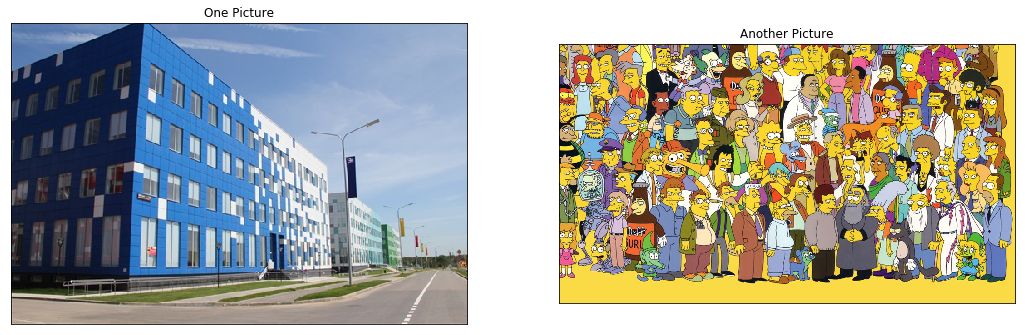

In [183]:
url1 = 'http://sk.ru/resized-image.ashx/__size/550x0/__key/communityserver-blogs-components-weblogfiles/00-00-00-60-11/skoltech1.jpg'
url2 = 'http://www.simpsoncrazy.com/content/characters/poster/bottom-right.jpg'
image_raw1 = Image.open(requests.get(url1, stream=True).raw)
image_raw2 = Image.open(requests.get(url2, stream=True).raw)

image1 = np.array(image_raw1).astype(np.uint8)
image2 = np.array(image_raw2).astype(np.uint8)

plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
plt.imshow(image_raw1)
plt.title('One Picture')
plt.xticks(())
plt.yticks(())

plt.subplot(1,2,2)
plt.imshow(image_raw2)
plt.title('Another Picture')
plt.xticks(())
plt.yticks(())

plt.show()

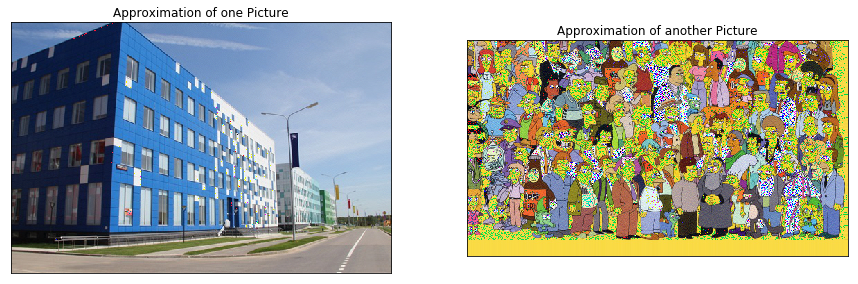

In [298]:
rank=200
new_image1,s=compress(image1,rank)
new_image2,s=compress(image2,rank)

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.title('Approximation of one Picture')
plt.xticks(())
plt.yticks(())
plt.imshow(new_image1)

plt.subplot(122)
plt.title('Approximation of another Picture')
plt.xticks(())
plt.yticks(())
plt.imshow(new_image2)

Compess of color transition has  worst approximation. 
Also largest ranks give better approximation because we increase number of 